In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
%matplotlib inline

from collections import Counter


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [3]:
train = pd.read_csv("./input/titanic/train.csv")
test = pd.read_csv("./input/titanic/test.csv")
IDtest = test["PassengerId"]

In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [13]:
# outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method
    """
    outlier_indices=[]
    
    #iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range(IQR)
        IQR = Q3-Q1

        # outlier step
        outlier_step = 1.5 * IQR

        #Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col]<Q1-outlier_step) | (df[col]>Q3+outlier_step)].index
        # append the found outlier indeces for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age", "SibSp", "Parch", "Fare"])

In [14]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [15]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [16]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [17]:
train_len =  len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [18]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [19]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [20]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [21]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


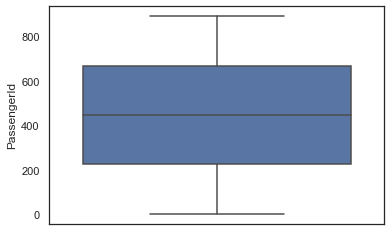

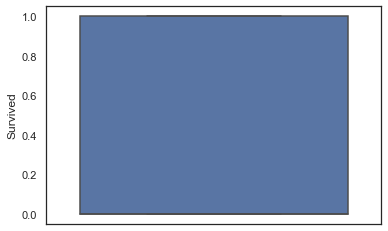

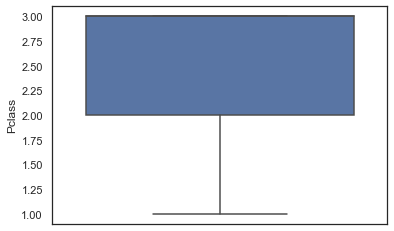

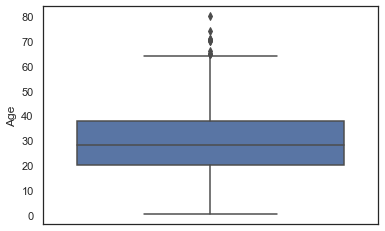

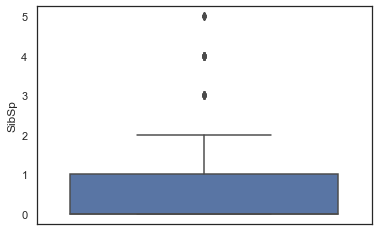

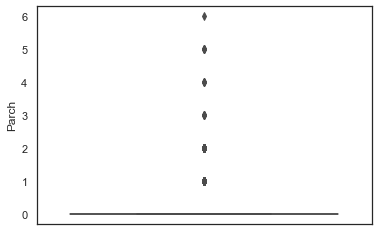

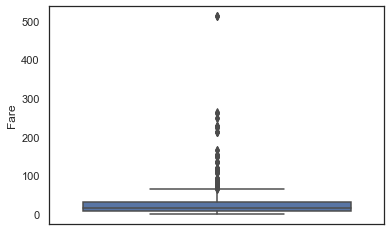

In [25]:
for col in train.columns:
    if train[col].dtype!='object':
        sns.boxplot(x=col, orient='v', data=train)
        plt.show()

In [30]:
numerical_col=["Survived", "SibSp", "Parch", "Age", "Fare"]

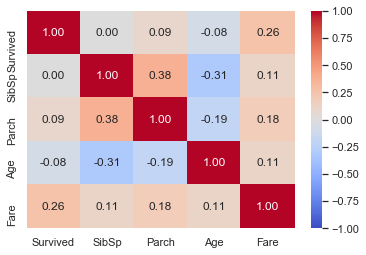

In [35]:
g = sns.heatmap(train[numerical_col].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)

In [36]:
train[numerical_col].corr()

,Survived,SibSp,Parch,Age,Fare
Survived,1.000000,0.003330,0.092819,-0.076867,0.264613
SibSp,0.003330,1.000000,0.379281,-0.307129,0.110072
Parch,0.092819,0.379281,1.000000,-0.186457,0.183801
Age,-0.076867,-0.307129,-0.186457,1.000000,0.110219
Fare,0.264613,0.110072,0.183801,0.110219,1.000000


### SibSP


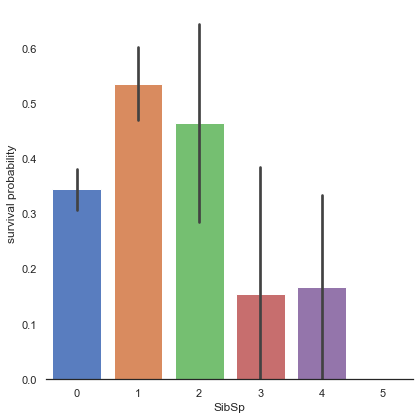

In [41]:
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Parch


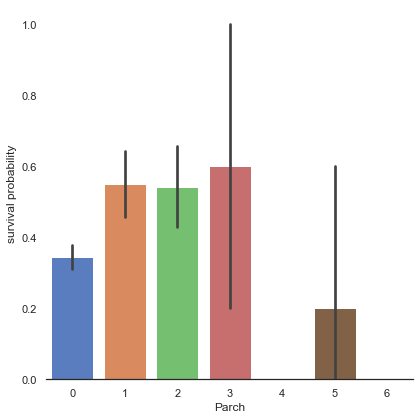

In [43]:
g = sns.factorplot(x="Parch", y="Survived", data=train, kind='bar', size=6,palette='muted')
g.despine(left=True)
g=g.set_ylabels("survival probability")

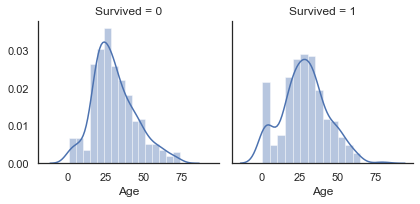

In [44]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

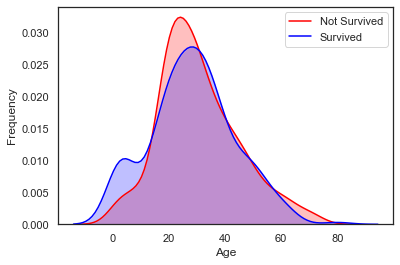

In [45]:
g=sns.kdeplot(train['Age'][(train["Survived"]==0) & train["Age"].notnull()], color='red', shade=True)
g=sns.kdeplot(train['Age'][(train["Survived"]==1) & train["Age"].notnull()], color='blue', shade=True, ax=g)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])



### Fare

In [46]:
dataset["Fare"].isnull().sum()

1

In [47]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

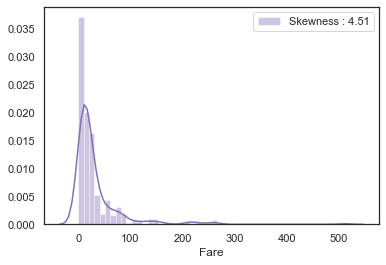

In [50]:
g = sns.distplot(dataset["Fare"], color='m', label='Skewness : {:.02f}'.format(dataset["Fare"].skew()))
g=g.legend(loc='best')

In [51]:
dataset["Fare_log"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

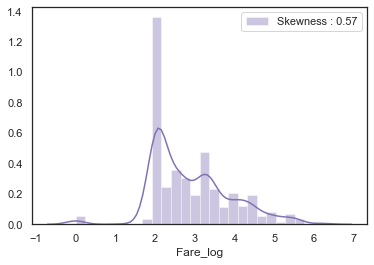

In [53]:
g = sns.distplot(dataset["Fare_log"], color='m', label='Skewness : {:.02f}'.format(dataset["Fare_log"].skew()))
g=g.legend(loc='best')

In [54]:
dataset["Fare"]=dataset["Fare_log"]

In [55]:
dataset["Fare"].skew()

0.5727996620084405

## 3.2 Categorical values
### sex

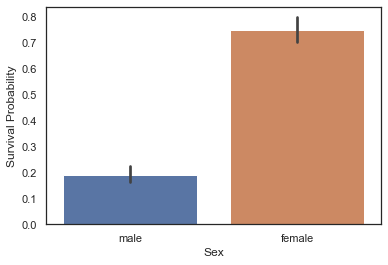

In [56]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survival Probability")

In [63]:
train[['Sex','Survived']].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


### Pclass


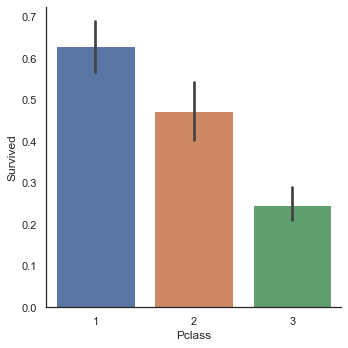

In [66]:
g = sns.factorplot(x='Pclass', y='Survived', kind='bar', data=dataset)

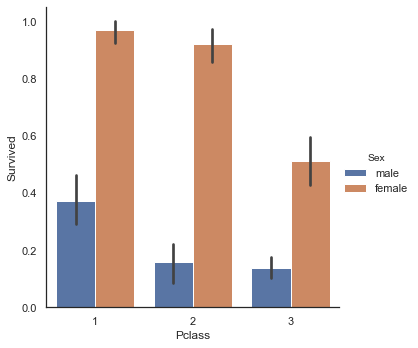

In [67]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=dataset)

In [69]:
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Fare_log          0
dtype: int64

In [70]:
dataset["Embarked"]

0       S
1       C
2       S
3       S
4       S
       ..
1294    S
1295    C
1296    S
1297    S
1298    C
Name: Embarked, Length: 1299, dtype: object

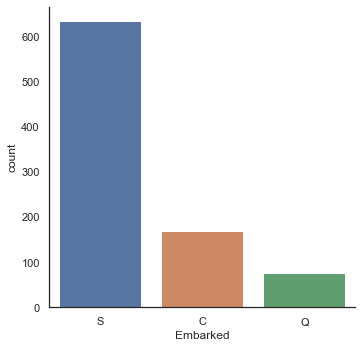

In [105]:
dataset["Embarked"].value_counts()
g=sns.factorplot(x='Embarked', data=train, kind="count")

In [93]:
dataset['Embarked']=
dataset["Embarked"].fillna("S")

In [94]:
dataset["Embarked"].isnull().sum()

0

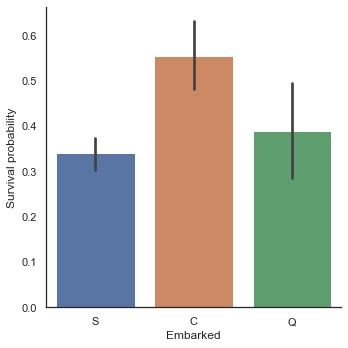

In [96]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, kind="bar")
g = g.set_ylabels("Survival probability")

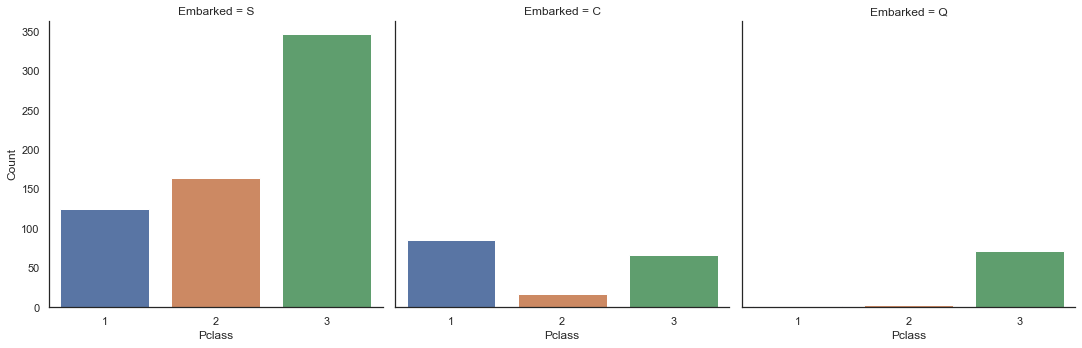

In [106]:
g = sns.factorplot(x='Pclass', col="Embarked", data=train, kind='count')
g= g.set_ylabels('Count')

# 4. Filling missing Values
## 4.1 Age

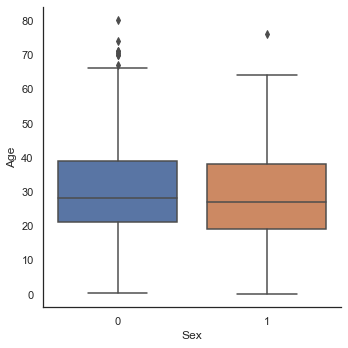

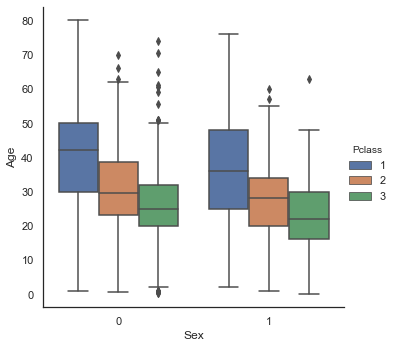

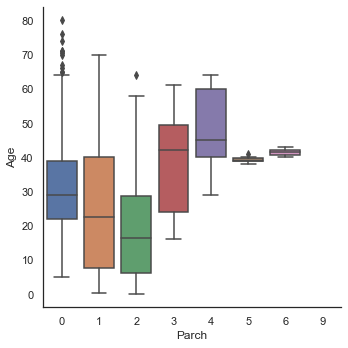

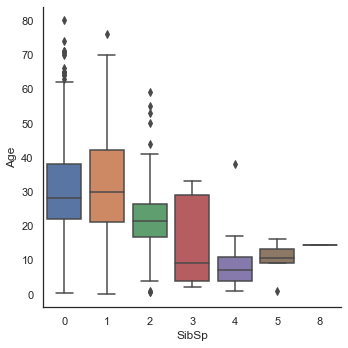

In [118]:
g = sns.factorplot(y="Age", x="Sex", data=dataset, kind='box')
g = sns.factorplot(y="Age", x="Sex", hue="Pclass",data=dataset, kind='box')
g = sns.factorplot(y="Age", x="Parch", data=dataset, kind='box')
g = sns.factorplot(y="Age", x="SibSp", data=dataset, kind='box')

In [109]:
dataset["Sex"]

0         male
1       female
2       female
3       female
4         male
         ...  
1294      male
1295    female
1296      male
1297      male
1298      male
Name: Sex, Length: 1299, dtype: object

In [110]:
dataset["Sex"]=dataset["Sex"].map({"female":1,"male":0})

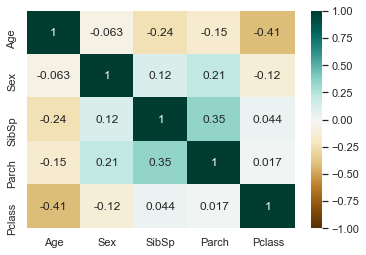

In [115]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(), cmap="BrBG", vmin=-1, vmax=1, annot=True)

In [125]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][(dataset["SibSp"]==dataset.iloc[i]["SibSp"]) &(dataset['Parch']==dataset.iloc[i]["Parch"])&(dataset["Pclass"]==dataset.iloc[i]['Pclass'])].median()
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med


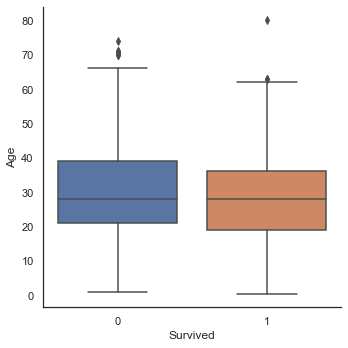

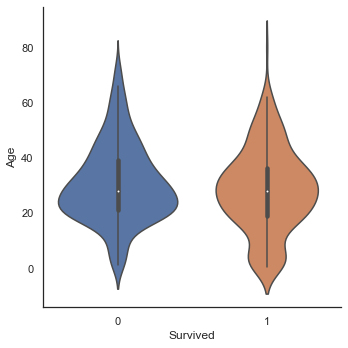

In [129]:
g = sns.factorplot(x="Survived", y = "Age", data= train, kind="box")
g = sns.factorplot(x="Survived", y = "Age", data=train, kind='violin')

# 5. Feature Engineering
## 5.1 Name/Title

In [131]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [142]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]

In [143]:
dataset["Title"]=pd.Series(dataset_title)

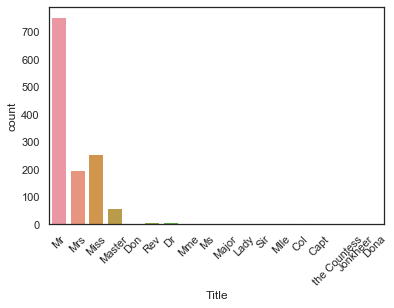

In [144]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [147]:
dataset["Title"] = dataset["Title"].replace(['Don', 'Rev','Dr','Major','Col','Capt','the Countess','Jonkheer','Dona','Lady','Sir'],'Rare')
dataset["Title"].value_counts()

Mr        753
Miss      255
Mrs       197
Master     60
Rare       29
Ms          2
Mlle        2
Mme         1
Name: Title, dtype: int64

In [149]:
dataset["Title"]=dataset["Title"].map({"Master":0, 'Miss':1, 'Mrs':1, 'Miss':1, 'Ms':1, 'Mlle':1, 'Mme':1, 'Mr':2, 'Rare':3})


In [150]:
dataset["Title"]=dataset["Title"].astype(int)

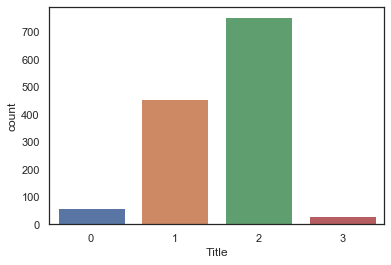

In [151]:
g = sns.countplot(dataset["Title"])

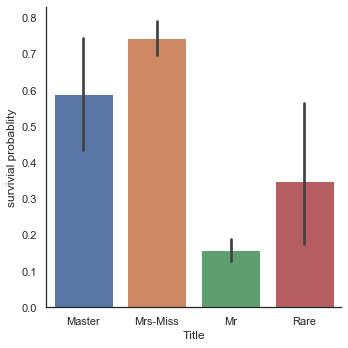

In [153]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind='bar')
g = g.set_xticklabels(["Master", "Mrs-Miss","Mr", "Rare"])
g = g.set_ylabels("survivial probablity")

In [158]:
dataset[['Age','Title']].groupby('Title').median()

,Age
Title,
0,6.0
1,25.0
2,27.0
3,47.0


## 5.2 Family Size


In [159]:
dataset["Fsize"]=dataset["SibSp"]+dataset["Parch"]+1

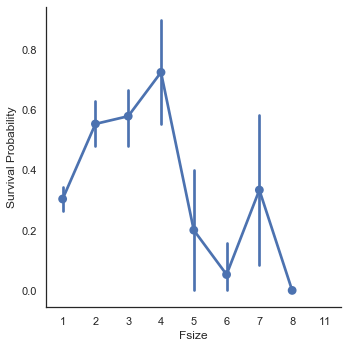

In [160]:
g = sns.factorplot(x="Fsize",y="Survived", data=dataset)
g = g.set_ylabels("Survival Probability")

In [168]:
dataset["Fsize_cat"]=pd.cut(dataset["Fsize"], [1,2,3,5,11], labels=['Single', 'SmallF','MedF','LargeF'], right=False)

In [171]:
dataset["Fsize"].head(10)

0    2
1    2
2    1
3    2
4    1
5    1
6    1
7    5
8    3
9    2
Name: Fsize, dtype: int64

In [180]:
dataset=pd.get_dummies(data=dataset, columns=['Fsize_cat'], prefix="", prefix_sep='')

In [181]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fare_log,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,1.981001,2,2,0,1,0,0
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,4.266662,1,2,0,1,0,0
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,2.070022,1,1,1,0,0,0
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,3.972177,1,2,0,1,0,0
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,2.085672,2,1,1,0,0,0


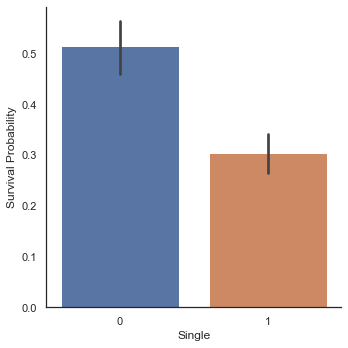

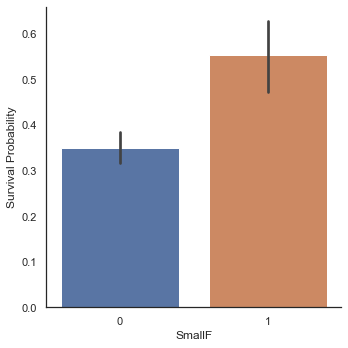

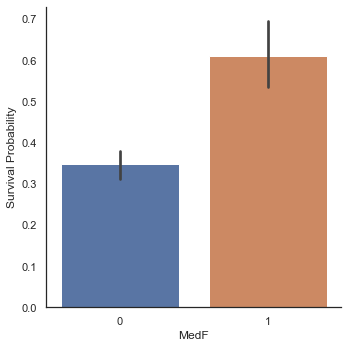

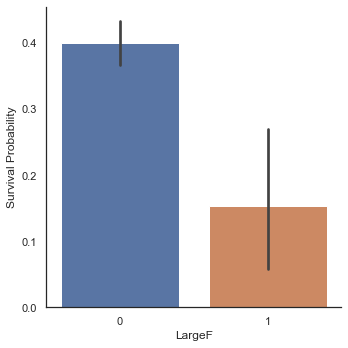

In [182]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [184]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fare_log,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,1.981001,2,2,0,1,0,0
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,4.266662,1,2,0,1,0,0
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,2.070022,1,1,1,0,0,0
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,3.972177,1,2,0,1,0,0
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,2.085672,2,1,1,0,0,0


In [185]:
dataset=pd.get_dummies(dataset, columns=["Title"])
dataset=pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [186]:
dataset.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [187]:
dataset.shape

(1299, 24)

## 5.3 Cabin

In [188]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [189]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [190]:
dataset["Cabin"].isnull().sum()

1007

In [191]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object